# Effect of Noise on Tracking of Linear State Space

## Simulating Observations from Systems

In [88]:
import math
import numpy as np

def generateDatafromSystem(system):
    X0=np.random.normal(scale=10,size=(4,)).T
    states=[X0]
    observations=[]
    H=np.array([[1, 0, 0, 0],
            [0, 1, 0, 0]])
    
    for i in range(0,100):
        if system=='A':
            F=np.array([[1, 0, 1, 0],[0, 1, 0, 1],[0, 0, 1, 0],[0, 0, 0, 1]])  
        else:
            F=np.array([[1, 0, 1+np.random.normal(scale=0.01), 0],[0, 1, 0, 1+np.random.normal(scale=0.01)],[0, 0, 1, 0],[0, 0, 0, 1]])
        
        states.append(F@states[-1]+np.random.normal(size=(4,)))
        observations.append(H@states[-1]+np.random.normal(size=(2,)))    
    
    return observations,states,H,X0

## Kalman Filter

In [108]:
import numpy as np
def Kalman( Observations, priorThetaMean, priorThetaVariance,transitionMatrix, transitionNoiseVariance, observationMatrix, observationNoiseVariance):
    ObservationPrediction = []
    ThetasPredictedMean = []
    ThetasPredictedVar = []
    ThetasPosteriorMean = []
    ThetasPosteriorVar = []
    SmoothedObservations = []
    ThetaMean= priorThetaMean
    ThetaVar = priorThetaVariance
    
    for i in range(0,len(Observations)):

        PredictionThetaMean = transitionMatrix@ThetaMean
 
        PredictionThetaVariance = transitionMatrix @ (ThetaVar @ transitionMatrix.T) + transitionNoiseVariance
        
        ThetasPredictedMean.append(PredictionThetaMean)
        ThetasPredictedVar.append(PredictionThetaVariance)
        ObservationPrediction.append( observationMatrix @ PredictionThetaMean )
     
        CovarianceOfInnovation =  observationMatrix @ ( PredictionThetaVariance @ observationMatrix.T)+ observationNoiseVariance
        OptimalKalmanGain = PredictionThetaVariance @ ( observationMatrix.T @ np.linalg.inv(CovarianceOfInnovation) )
        
        Innovation = Observations[i] - np.matmul( observationMatrix,PredictionThetaMean )
       
        ThetaMean = PredictionThetaMean + np.matmul(OptimalKalmanGain,Innovation)
        
        ThetaVar = np.matmul((np.identity(transitionMatrix.shape[0])-np.matmul( OptimalKalmanGain,observationMatrix)) , PredictionThetaVariance)
        
        SmoothedObservations.append( observationMatrix @ ThetaMean )
        ThetasPosteriorMean.append(ThetaMean)
        ThetasPosteriorVar.append(ThetaVar)
    
    return ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations

## Applying Kalman Filter on System A

In [109]:
from sklearn.metrics import mean_squared_error
MSEs=[]
for i in range(0,100):
    observations,states,H,X0 = generateDatafromSystem('A')
    F=np.array([[1, 0, 1, 0],[0, 1, 0, 1],[0, 0, 1, 0],[0, 0, 0, 1]])
    ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations= Kalman( observations, X0, np.eye(4)*1, F, np.eye(4), H, np.eye(2))
    ThetasPosteriorMean=np.array(ThetasPosteriorMean)
    states=np.array(states)
    MSEs.append(math.sqrt(mean_squared_error(states[1:,0:2],ThetasPosteriorMean[:,0:2],multioutput='uniform_average')))

In [110]:
np.mean(MSEs)

0.9061244009434702

In [111]:
np.var(MSEs)

0.0017437867698824302

Text(0, 0.5, 'y')

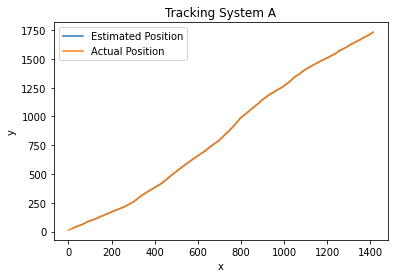

In [112]:
plt.plot(ThetasPosteriorMean[:,0],ThetasPosteriorMean[:,1],label='Estimated Position')
plt.plot(states[:,0],states[:,1],label='Actual Position')

plt.legend()
plt.title('Tracking System A')
plt.xlabel('x')
plt.ylabel('y')

## Applying Kalman Filter to System B

In [113]:
from sklearn.metrics import mean_squared_error
MSEs=[]
for i in range(0,100):
    observations,states,H,X0 = generateDatafromSystem('B')
    F=np.array([[1, 0, 1, 0],[0, 1, 0, 1],[0, 0, 1, 0],[0, 0, 0, 1]])
    ObservationPrediction ,ThetasPredictedMean , ThetasPredictedVar,ThetasPosteriorMean, ThetasPosteriorVar,SmoothedObservations= Kalman( observations, X0, np.eye(4)*1, F, np.eye(4), H, np.eye(2))
    ThetasPosteriorMean=np.array(ThetasPosteriorMean)
    states=np.array(states)
    MSEs.append(math.sqrt(mean_squared_error(states[1:,0:2],ThetasPosteriorMean[:,0:2],multioutput='uniform_average')))

In [114]:
np.mean(MSEs)

0.9097005765389174

In [115]:
np.var(MSEs)

0.0026935631171997546

Text(0, 0.5, 'y')

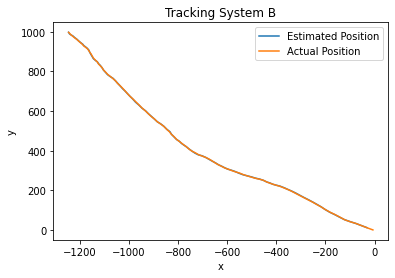

In [118]:
plt.plot(ThetasPosteriorMean[:,0],ThetasPosteriorMean[:,1],label='Estimated Position')
plt.plot(states[:,0],states[:,1],label='Actual Position')

plt.legend()
plt.title('Tracking System B')
plt.xlabel('x')
plt.ylabel('y')

# Effect of Noise on Tracking of Non linear State Space

In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint


In [2]:
import math
def model4(y,t,b,noise):
    a=1+noise*np.random.normal(scale=0.01)
    x=y[0]
    ys=y[1]
    b= b+noise*np.random.normal(scale=0.01)
    dydt = b*x-x*x*ys
    dxdt =  a-(b+1)*x +x*x*ys
    return [dxdt,dydt]

    

In [3]:
def generateNonLinear(system):
    y=[[1,0.5]]
    if system=='C':
        noise=0
    else:
        noise=1
        
    for i in range(300):
        t=np.linspace(0, 0.10, 2)
        thetanew=odeint( model4 , y[-1] , t ,args=(4,noise))
        thetanew=thetanew[-1]
        thetanew= [x+np.random.normal(scale=0.01) for x in thetanew]
        y.append(thetanew)
    y=np.array(y)
    yobserved = np.copy(y)
    yobserved[:,0]=[x+np.random.normal() for x in y[:,0]]
    yobserved[:,1]=[x+np.random.normal() for x in y[:,1]]
    
    return y,yobserved
    

## Particle filter

In [13]:
def transition_model(theta,sigma=0.01):
    t=np.linspace(0, 0.10, 2)
    y=odeint( model4 , theta  ,t,args=(4,0))
    y=y+np.random.normal(scale=sigma)
    return y[1]

def measurement_model(theta):
    observation=[x+np.random.normal() for x in theta]
    
    return observation

In [6]:
import math
def normpdf(x, mean, var):
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [7]:
def getLikelihood(estimatedObservation,measurement):
    Likelihood=1
    for i in range(len(estimatedObservation)):
        Likelihood = Likelihood*normpdf(estimatedObservation[i],measurement[i],1)
    return Likelihood

In [15]:
def particle_filter(num_particles, initial_state, measurements,sigma=0.01):
    particles= []
    for i in range(0,num_particles):
        particles.append(np.random.normal(0, 2, size=(initial_state.shape[0],)))
    particles=np.array(particles)
    weights = np.ones(num_particles) / num_particles
    weights= np.float64(weights)
    estimates=[]
    variances=[]
    for measurement in measurements:
        likelihoods = []
        for i in range(0,len(particles)):
            
            new_theta = transition_model(particles[i],sigma) 
            particles[i]= new_theta
           
            estimatedObservation = measurement_model(particles[i])
            
            likelihood= getLikelihood(estimatedObservation,measurement)
            
            likelihoods.append(likelihood)
        
        weights *=likelihoods / np.sum(likelihoods) 
        
        weights /= np.sum(weights) 
        #Estimates
        temp= np.average(particles, axis=0, weights=weights)
        estimates.append(measurement_model(temp))
        #Resampling
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles
        variances.append(np.var(particles, axis=0))
           
    return estimates,variances

### Applying to System C

In [34]:
from sklearn.metrics import mean_squared_error


y,yobserved = generateNonLinear('C')
esti,var=particle_filter(5000, np.array([1,0.5]), yobserved)
esti=np.array(esti)
MSEs.append(math.sqrt(mean_squared_error(y,esti,multioutput='uniform_average')))

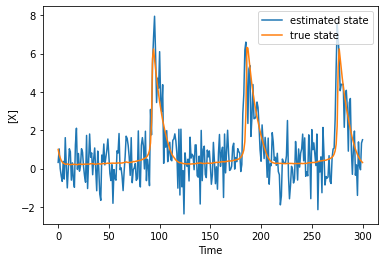

Text(0, 0.5, '[Y]')

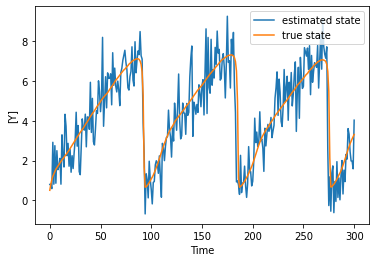

In [39]:
plt.plot(esti[:,0],label='estimated state')
plt.plot(y[:,0],label='true state')

plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
plt.plot(esti[:,1],label='estimated state')
plt.plot(y[:,1],label='true state')

plt.legend()
plt.xlabel('Time')
plt.ylabel('[Y]')

### Applying Particle Filter to System D


In [107]:

from sklearn.metrics import mean_squared_error
sigma=0.01
y,yobserved = generateNonLinear('D')
esti,var=particle_filter(5000, np.array([1,0.5]), yobserved,sigma=sigma)
esti=np.array(esti)
math.sqrt(mean_squared_error(y,esti,multioutput='uniform_average'))

2.900720661474209

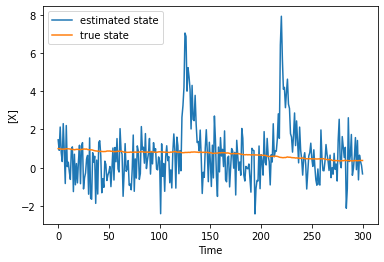

Text(0, 0.5, '[Y]')

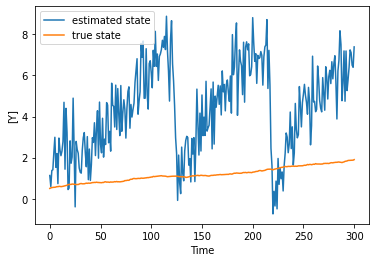

In [108]:
plt.plot(esti[:,0],label='estimated state')
plt.plot(y[:,0],label='true state')

plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
plt.plot(esti[:,1],label='estimated state')
plt.plot(y[:,1],label='true state')

plt.legend()
plt.xlabel('Time')
plt.ylabel('[Y]')

## Signature Based Particle Filter

### Up to 1st level of Signature

In [6]:
def transition_model(theta,varianceApprox,time):
    deltaX1= theta[0]/time+ np.random.normal(loc=0,scale=varianceApprox) 
    deltaX2= theta[1]/time+np.random.normal(loc=0,scale=varianceApprox)
    F = np.eye(2)
    
    
    noise = np.array([
                        deltaX1,
                        deltaX2
                    ])
    noise=noise.T
    
    theta = F@theta +  noise
    return theta

def measurement_model(theta):
    measurement=np.copy(theta)
    for i in range(len(theta)):
       
        measurement[i]=measurement[i]+np.random.normal()
        
   
    return measurement

In [7]:
import math
def normpdf(x, mean, var):
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [8]:
def getLikelihood(estimatedObservation,measurement):
    Likelihood=1
    for i in range(len(measurement)):
        Likelihood = Likelihood*normpdf(estimatedObservation[i],measurement[i],1)
    return Likelihood

In [9]:
def particle_filter(num_particles, initial_state, measurements,varianceApprox):
    particles= []
    for i in range(0,num_particles):
        particles.append(np.zeros((initial_state.shape[0],)))
    particles=np.array(particles)
    weights = np.ones(num_particles) / num_particles
    weights= np.float64(weights)
    estimates=[]
    variances=[]
    time=1
    
    for measurement in measurements:
        likelihoods = []
        for i in range(0,len(particles)):
            
            new_theta = transition_model(particles[i],varianceApprox,time)
            particles[i]= new_theta
       
            estimatedObservation = measurement_model(particles[i])
            
            likelihood= getLikelihood(estimatedObservation,measurement)
            
            likelihoods.append(likelihood)
        
        weights *=likelihoods / np.sum(likelihoods) 
        
        weights /= np.sum(weights) 
        #Estimates
        temp= np.average(particles, axis=0, weights=weights)
        estimates.append(temp[0:2])
        #Resampling
       
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles
        variances.append(np.var(particles, axis=0))
        time+=1
    return estimates,variances

### System C

In [ ]:
import iisignature
y,yobserved = generateNonLinear('D')
Signatures = [np.zeros((2,))]

for i in range(1,yobserved.shape[0]):
    Signature=iisignature.sig(yobserved[0:i+1],1)
    Signatures.append(Signature)

In [ ]:
from sklearn.metrics import mean_squared_error
vars=[2,4,8,16] 
for var in vars:
    temp,variances=particle_filter(5000, np.zeros(2,), Signatures,var)
    temp=[x+[1,0.5] for x in temp]
    temp=np.array(temp)
    print(var)
    print(math.sqrt(mean_squared_error(y,temp,multioutput='uniform_average')))
    plt.plot(temp[:,0],label='estimated state')
    plt.plot(y[:,0],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[X]')
    plt.show()
    plt.plot(temp[:,1],label='estimated state')
    plt.plot(y[:,1],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[Y]')
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
vars=[2,4,8,16] 
for var in vars:
    temp,variances=particle_filter(5000, np.zeros(2,), Signatures,var)
    temp=[x+[1,0.5] for x in temp]
    temp=np.array(temp)
    print(var)
    print(math.sqrt(mean_squared_error(y,temp,multioutput='uniform_average')))
    plt.plot(temp[:,0],label='estimated state')
    plt.plot(y[:,0],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[X]')
    plt.show()
    plt.plot(temp[:,1],label='estimated state')
    plt.plot(y[:,1],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[Y]')
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
vars=[2,4,8,16] 
for var in vars:
    temp,variances=particle_filter(5000, np.zeros(2,), Signatures,var)
    temp=[x+[1,0.5] for x in temp]
    temp=np.array(temp)
    print(var)
    print(math.sqrt(mean_squared_error(y,temp,multioutput='uniform_average')))
    plt.plot(temp[:,0],label='estimated state')
    plt.plot(y[:,0],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[X]')
    plt.show()
    plt.plot(temp[:,1],label='estimated state')
    plt.plot(y[:,1],label='true state')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('[Y]')
    plt.show()

### Up to 2nd level of signature

In [214]:
def transition_model(theta,varianceApprox,time):
    deltaX1= theta[0]/time+ np.random.normal(loc=0,scale=varianceApprox) 
    deltaX2= theta[1]/time+np.random.normal(loc=0,scale=varianceApprox)
    F = np.eye(6)
    F[2, 0] = deltaX1
    F[3, 0] = deltaX2
    F[4, 1] = deltaX1
    F[5, 1] = deltaX2
    
    noise = np.array([
                        deltaX1,
                        deltaX2,
                        (deltaX1**2)/2,
                        (deltaX1*deltaX2)/2,
                        (deltaX1*deltaX2)/2,
                        (deltaX2**2)/2
                    ])
    noise=noise.T
    
    theta = F@theta +  noise
    return theta
from scipy.stats import chi2
def measurement_model(theta,time):
    measurement=np.copy(theta)
    for i in range(len(theta)):
        if(i<2):
            measurement[i]=measurement[i]+np.random.normal()
        else:
            measurement[i]=measurement[i]+chi2.rvs(time,size=1)
   
    return measurement

In [215]:
import math
def normpdf(x, mean, var):
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [216]:
from scipy.stats import chi2
def getLikelihood(estimatedObservation,measurement,df):
    Likelihood=1
    for i in range(0,2):
        Likelihood = Likelihood*normpdf(estimatedObservation[i],measurement[i],1)
    for i in range(2,len(estimatedObservation)):
        Likelihood = Likelihood*chi2.pdf(estimatedObservation[i]-measurement[i], df)
    return Likelihood

In [217]:
def particle_filter(num_particles, initial_state, measurements,varianceApprox,df):
    particles= []
    for i in range(0,num_particles):
        particles.append(np.zeros((initial_state.shape[0],)))
    particles=np.array(particles)
    weights = np.ones(num_particles) / num_particles
    weights= np.float64(weights)
    estimates=[]
    variances=[]
    startingPoint=np.copy(particles)
    time=1
    
    for measurement in measurements:
        likelihoods = []
        for i in range(0,len(particles)):
            
            new_theta = transition_model(particles[i],varianceApprox,time)
            particles[i]= new_theta
       
            estimatedObservation = measurement_model(particles[i],df)
            
            likelihood= getLikelihood(estimatedObservation,measurement,df)
            
            likelihoods.append(likelihood)
        
        weights *=likelihoods / np.sum(likelihoods) 
        
        weights /= np.sum(weights) 
        #Estimates
        temp= np.average(particles, axis=0, weights=weights)
        estimates.append(temp[0:2])
        #Resampling
       
        indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=weights)
        particles = particles[indices]
        startingPoint=startingPoint[indices]
        weights = np.ones(num_particles) / num_particles
        variances.append(np.var(particles, axis=0))
        time+=1
    start=np.average(startingPoint,axis=0)       
    return estimates,variances,start

#### System C

In [218]:
import iisignature
y,yobserved = generateNonLinear('C')
Signatures = [np.zeros((6,))]

for i in range(1,yobserved.shape[0]):
    Signature=iisignature.sig(yobserved[0:i+1],2)
    Signatures.append(Signature)

In [221]:
temp,variancesPF,start=particle_filter(1000, np.zeros(6,), Signatures,2,32)
temp=[x+[1,0.5] for x in temp]
temp=np.array(temp)

In [ ]:
plt.plot(temp[:,0])
plt.plot(y[:,0])

In [ ]:
plt.plot(temp[:,1])
plt.plot(y[:,1])

In [ ]:
from sklearn.metrics import mean_squared_error
MSEs= np.zeros((6,4))
dfs=[2,4,8,16,32,64]
variances = [2,4,8,16]
for df in range(len(dfs)):
    for var in range(len(variances)):
        print(dfs[df])
        print(variances[var])
        temp,variancesPF,start=particle_filter(5000, np.zeros(6,), Signatures,variances[var],dfs[df])
        temp=[x+[1,0.5] for x in temp]
        temp=np.array(temp)
        MSEcurrent=math.sqrt(mean_squared_error(y,temp,multioutput='uniform_average'))
        print(MSEcurrent)
        MSEs[df,var]=MSEcurrent
    

#### System D

In [21]:
import iisignature
y,yobserved = generateNonLinear('D')
Signatures = [np.zeros((6,))]

for i in range(1,yobserved.shape[0]):
    Signature=iisignature.sig(yobserved[0:i+1],2)
    Signatures.append(Signature)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [ ]:
from sklearn.metrics import mean_squared_error
MSEs= np.zeros((6,4))
dfs=[2,4,8,16,32,64]
variances = [2,4,8,16]
for df in range(len(dfs)):
    for var in range(len(variances)):
        print(dfs[df])
        print(variances[var])
        temp,variancesPF,start=particle_filter(5000, np.zeros(6,), Signatures,variances[var],dfs[df])
        temp=[x+[1,0.5] for x in temp]
        temp=np.array(temp)
        MSEcurrent=math.sqrt(mean_squared_error(y,temp,multioutput='uniform_average'))
        print(MSEcurrent)
        MSEs[df,var]=MSEcurrent